In [ ]:
%load_ext autoreload
%autoreload 2
from ais_dataloader import *
from gp_kernel_ship_classification_dataset import *
from gp_kernel_ship_classification_trainer import *
from gp_kernel_ship_classification_network import *
from multioutput_rbf_linear_gp import *


import ipywidgets as widgets
from IPython.display import display
from plotting_utils import *
from tqdm.notebook import tqdm
from IPython.display import clear_output
import time
import os
import torch
import gpytorch
import datetime
import seaborn as sns


# sns.set(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load Data

The cell below loads in AIS traectories from a specified date range and processes them to form a regression dataset. Modify the start and end date in date_range as desired, but leave the frequency at 'D'.

NOTE: The dataset class does not currently handle the download of the daily csv data. Users should download the desired date range by using the cli as specified in the README.

Loading cached dataframe from data/processed/processed_AIS_df_2024_01_01_2024_01_01.pkl


Scaling trajectories for each MMSI: 100%|██████████| 3453/3453 [00:01<00:00, 2121.67it/s]



===== Dataset Statistics =====
Total number of AIS messages: 2128288
Number of unique MMSIs: 3453
Date range: 2024-01-01 00:00:00 to 2024-01-01 23:59:59
Number of vessel groups: 9


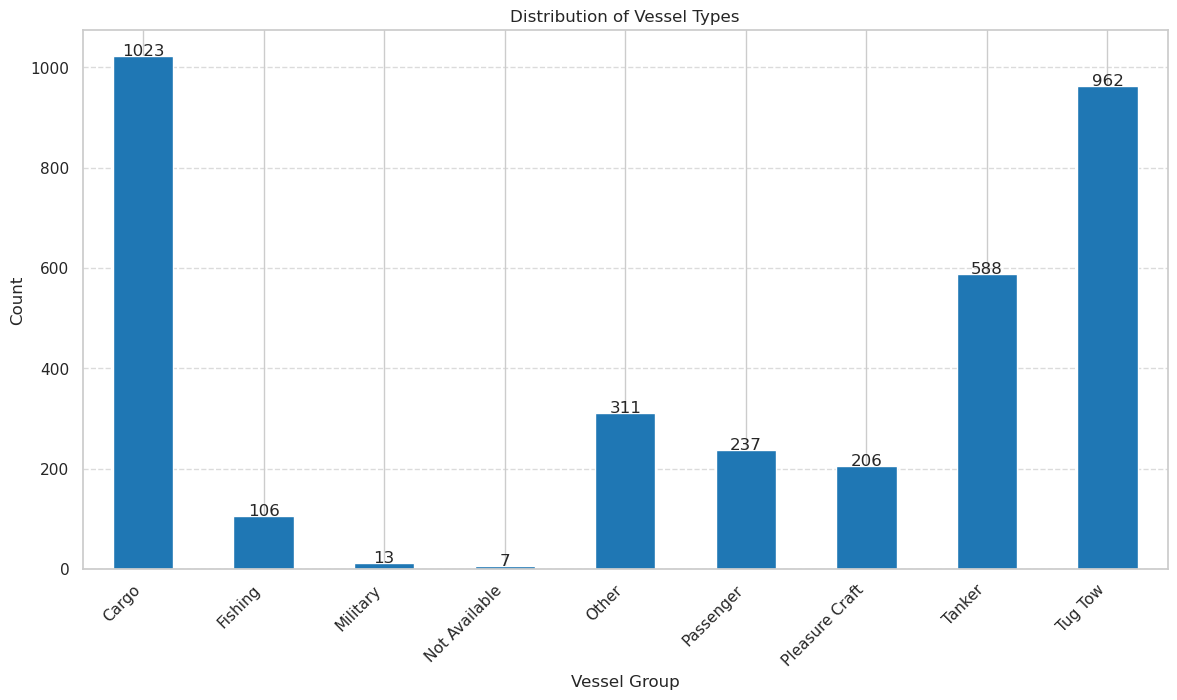

In [2]:
date_range = pd.date_range(start='2024-01-01', end='2024-01-01', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)

# Display vessel group histogram
group_counts = gp_regression_dataset.plot_vessel_group_histogram(figsize=(14, 7))

## Fit GP Models

In [ ]:
# # Control flag - set to True to load existing models if available, False to force retraining
# reload_existing_models = True

# # Get the full dataset
# date_range = pd.date_range(start='2024-01-01', end='2024-01-02', freq='D')
# gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)

# num_trajectories = len(gp_regression_dataset)
# models = {}
# likelihoods = {}
# losses = {}

# # Create a filename based on the dataset's date range and number of trajectories
# start_date = date_range[0].strftime('%Y-%m-%d')
# end_date = date_range[-1].strftime('%Y-%m-%d')

# # If it's a single day, use just one date, otherwise show the range
# if start_date == end_date:
#     date_identifier = start_date
# else:
#     date_identifier = f"{start_date}_to_{end_date}"

# # Define model file path with number of trajectories included
# save_dir = "models"
# os.makedirs(save_dir, exist_ok=True)
# save_path = f"{save_dir}/rbf_and_linear_kernel_classification_bundle_{date_identifier}_n{num_trajectories}.pt"

# # First check if models with the exact date range already exist
# if os.path.exists(save_path) and reload_existing_models:
#     print(f"Found existing model bundle for date range {date_identifier} with {num_trajectories} trajectories")
#     print(f"Loading models from {save_path} instead of retraining...")
    
#     # Load the existing models
#     bundle = torch.load(save_path)
#     models_state_dict = bundle["models_state_dict"]
#     likelihoods_state_dict = bundle["likelihoods_state_dict"] 
#     losses = bundle.get("losses", {})
    
#     # Verify the model count matches expected count
#     if len(models_state_dict) != num_trajectories:
#         print(f"Warning: Loaded {len(models_state_dict)} models but expected {num_trajectories}")
    
#     # Reconstruct models from state dictionaries
#     for mmsi, state_dict in tqdm(models_state_dict.items(), desc="Loading models"):
#         # Get the corresponding data for this MMSI
#         times, state_trajectory = None, None
#         for entry in gp_regression_dataset:
#             if entry[0] == mmsi:
#                 _, times, state_trajectory = entry
#                 break
#         if times is None:
#             print(f"Warning: Could not find data for MMSI {mmsi}, skipping")
#             continue

#         X = times.detach().unsqueeze(1).to(device)
#         Y = state_trajectory.detach().to(device)
#         num_outputs = Y.shape[1]
        
#         likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
#             num_tasks=num_outputs
#         ).to(device)
        
#         model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)
        
#         # Load the state dictionaries
#         model.load_state_dict(state_dict)
#         if mmsi in likelihoods_state_dict:
#             likelihood.load_state_dict(likelihoods_state_dict[mmsi])
        
#         models[mmsi] = model
#         likelihoods[mmsi] = likelihood
    
#     print(f"Successfully loaded {len(models)} models")
    
# elif reload_existing_models:
#     print(f"No exact match found for date range {date_identifier}. Looking for partial date bundles...")
    
#     # Check for models that cover any days within our date range
#     partial_bundles = []
    
#     # Find model bundles for individual days or smaller ranges within our target range
#     import re
#     for filename in os.listdir(save_dir):
#         if not filename.startswith("rbf_and_linear_kernel_classification_bundle_"):
#             continue
            
#         # Extract date information from filename
#         match = re.search(r'bundle_(\d{4}-\d{2}-\d{2})(?:_to_(\d{4}-\d{2}-\d{2}))?_n(\d+)', filename)
#         if not match:
#             continue
            
#         bundle_start = match.group(1)
#         bundle_end = match.group(2) if match.group(2) else bundle_start
#         bundle_count = int(match.group(3))
        
#         # Convert to datetime for comparison
#         bundle_start_date = pd.to_datetime(bundle_start)
#         bundle_end_date = pd.to_datetime(bundle_end)
        
#         # Check if any part of this bundle overlaps with our requested date range
#         requested_start = pd.to_datetime(start_date)
#         requested_end = pd.to_datetime(end_date)
        
#         # Check for overlap
#         if (bundle_start_date <= requested_end and bundle_end_date >= requested_start):
#             # There's overlap, add this bundle to our list
#             bundle_dates = pd.date_range(start=bundle_start, end=bundle_end, freq='D')
#             partial_bundles.append((bundle_dates, os.path.join(save_dir, filename), bundle_count))
    
#     if partial_bundles:
#         print(f"Found {len(partial_bundles)} partial bundles that overlap with requested date range.")
        
#         # Dictionary to track which MMSIs we've loaded for each date
#         loaded_mmsis_by_date = {date: set() for date in date_range}
        
#         # Load models from all partial bundles
#         for bundle_dates, bundle_path, bundle_count in partial_bundles:
#             print(f"Loading models from {os.path.basename(bundle_path)}")
#             bundle = torch.load(bundle_path)
#             models_state_dict = bundle["models_state_dict"]
#             likelihoods_state_dict = bundle["likelihoods_state_dict"]
#             bundle_losses = bundle.get("losses", {})
            
#             # Load models
#             for mmsi, state_dict in tqdm(models_state_dict.items(), desc=f"Loading from bundle"):
#                 # Get the corresponding data for this MMSI
#                 times, state_trajectory, date_for_mmsi = None, None, None
#                 for entry in gp_regression_dataset:
#                     if entry[0] == mmsi:
#                         _, times, state_trajectory = entry
#                         # Extract the date for this MMSI
#                         date_for_mmsi = entry[3] if len(entry) > 3 else None
#                         break
                
#                 if times is None:
#                     continue  # Skip if MMSI not found
                
#                 # Skip if we already loaded this MMSI for this date
#                 if date_for_mmsi and mmsi in loaded_mmsis_by_date.get(date_for_mmsi, set()):
#                     continue
                
#                 X = times.detach().unsqueeze(1).to(device)
#                 Y = state_trajectory.detach().to(device)
#                 num_outputs = Y.shape[1]
                
#                 likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
#                     num_tasks=num_outputs
#                 ).to(device)
                
#                 model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)
                
#                 # Load the state dictionaries
#                 model.load_state_dict(state_dict)
#                 if mmsi in likelihoods_state_dict:
#                     likelihood.load_state_dict(likelihoods_state_dict[mmsi])
                
#                 models[mmsi] = model
#                 likelihoods[mmsi] = likelihood
#                 if mmsi in bundle_losses:
#                     losses[mmsi] = bundle_losses[mmsi]
                
#                 # Mark this MMSI as loaded for its date
#                 if date_for_mmsi:
#                     loaded_mmsis_by_date[date_for_mmsi].add(mmsi)
        
#         print(f"Successfully loaded {len(models)} models from partial bundles")
        
#         # Now train models for any remaining MMSIs
#         remaining_mmsis = []
#         for idx, entry in enumerate(gp_regression_dataset):
#             mmsi = entry[0]
#             if mmsi not in models:
#                 remaining_mmsis.append((idx, mmsi))
        
#         if remaining_mmsis:
#             print(f"Training {len(remaining_mmsis)} additional models for missing MMSIs...")
            
#             # Track timing information for ETA calculation
#             start_time = time.time()
#             processed_count = 0
#             avg_time_per_model = None
            
#             # Create outer progress bar for overall tracking
#             overall_pbar = tqdm(total=len(remaining_mmsis), desc="Training Additional Models", position=0)
            
#             try:
#                 for idx, mmsi in remaining_mmsis:
#                     # Clear previous iteration output
#                     clear_output(wait=True)
                    
#                     # Get the data for this MMSI
#                     entry = gp_regression_dataset[idx]
#                     _, times, state_trajectory = entry
                    
#                     # Recalculate and display ETA
#                     if processed_count > 0:
#                         elapsed = time.time() - start_time
#                         avg_time_per_model = elapsed / processed_count
#                         remaining_models = len(remaining_mmsis) - processed_count
#                         eta_seconds = avg_time_per_model * remaining_models
#                         eta_str = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))
                        
#                         # Display progress summary
#                         print(f"Training Additional Models: {processed_count}/{len(remaining_mmsis)} completed")
#                         print(f"Average time per model: {avg_time_per_model:.2f} seconds")
#                         print(f"Estimated time remaining: {eta_str}")
#                     else:
#                         print(f"Training Additional Models: Starting...")
                    
#                     # Show overall progress bar
#                     overall_pbar.display()
                    
#                     print(f"\nFitting model for MMSI {mmsi} (#{processed_count+1}/{len(remaining_mmsis)})")
                    
#                     X = times.detach().unsqueeze(1).to(device)
#                     Y = state_trajectory.detach().to(device)
                    
#                     num_outputs = Y.shape[1]
                    
#                     likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
#                         num_tasks=num_outputs, 
#                         # noise_prior=gpytorch.priors.NormalPrior(loc=0.25, scale=0.25)
#                     ).to(device)
                    
#                     model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)
                    
#                     session_id = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
                    
#                     with gpytorch.settings.cholesky_jitter(1e-3):
#                         loss, model, likelihood = train_model(model, likelihood, X, Y, num_epochs=50, lr=0.1, mmsi=mmsi, session_id=session_id)
                    
#                     # Store results
#                     models[mmsi] = model
#                     likelihoods[mmsi] = likelihood
#                     losses[mmsi] = loss.item()
                    
#                     # Update counters and progress
#                     processed_count += 1
#                     overall_pbar.update(1)
                    
#             finally:
#                 overall_pbar.close()
                
#             # Display completion message with timing stats
#             if processed_count > 0:
#                 total_time = time.time() - start_time
#                 hours, remainder = divmod(total_time, 3600)
#                 minutes, seconds = divmod(remainder, 60)
#                 print(f"Successfully trained {processed_count} additional models")
#                 print(f"Total time elapsed: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")
#                 print(f"Average time per model: {total_time/processed_count:.2f} seconds")
            
#             print(f"Total models: {len(models)}")
            
#         else:
#             print("All required models loaded from partial bundles. No additional training needed.")
        
#         # Save the complete bundle
#         save_dict = {
#             "models_state_dict": {k: v.state_dict() for k, v in models.items()},
#             "likelihoods_state_dict": {k: v.state_dict() for k, v in likelihoods.items()},
#             "losses": losses,
#             "date_range": [start_date, end_date],
#             "num_trajectories": len(models)
#         }
        
#         torch.save(save_dict, save_path)
#         print(f"Saved complete model bundle to {save_path}")
    
#     else:
#         print("No partial bundles found. Training all models from scratch...")
#         need_full_training = True
# else:
#     # Check if we need to train new models
#     if os.path.exists(save_path) and not reload_existing_models:
#         print(f"Models exist at {save_path} but reload_existing_models=False, retraining...")
#     else:
#         print(f"No existing models found for date range {date_identifier} with {num_trajectories} trajectories")
    
#     need_full_training = True

# # Original training code for training all models from scratch
# if 'need_full_training' in locals() or not reload_existing_models:
#     print("Starting training process...")
    
#     # Track timing information for ETA calculation
#     start_time = time.time()
#     processed_count = 0
#     avg_time_per_model = None

#     # Create outer progress bar for overall tracking
#     overall_pbar = tqdm(total=num_trajectories, desc="Overall Progress", position=0)

#     try:
#         for idx in range(num_trajectories):
#             # Clear previous iteration output
#             clear_output(wait=True)
            
#             # Recalculate and display ETA
#             if processed_count > 0:
#                 elapsed = time.time() - start_time
#                 avg_time_per_model = elapsed / processed_count
#                 remaining_models = num_trajectories - processed_count
#                 eta_seconds = avg_time_per_model * remaining_models
#                 eta_str = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))
                
#                 # Display progress summary
#                 print(f"Fitting GP Models: {processed_count}/{num_trajectories} completed")
#                 print(f"Average time per model: {avg_time_per_model:.2f} seconds")
#                 print(f"Estimated time remaining: {eta_str}")
#             else:
#                 print(f"Fitting GP Models: Starting...")
            
#             # Show overall progress bar
#             overall_pbar.display()
            
#             # Get data for current model
#             mmsi, times, state_trajectory = gp_regression_dataset[idx]
#             print(f"\nFitting model for MMSI {mmsi} (#{idx+1}/{num_trajectories})")
            
#             X = times.detach().unsqueeze(1).to(device)
#             Y = state_trajectory.detach().to(device)
            
#             num_outputs = Y.shape[1]
            
#             likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
#                 num_tasks=num_outputs, 
#                 # noise_prior=gpytorch.priors.NormalPrior(loc=0.25, scale=0.25)
#             ).to(device)
            
#             model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)

#             session_id = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

#             with gpytorch.settings.cholesky_jitter(1e-3):
#                 loss, model, likelihood = train_model(model, likelihood, X, Y, num_epochs=50, lr=0.1, mmsi=mmsi, session_id=session_id)
            
#             # Store results
#             models[mmsi] = model
#             likelihoods[mmsi] = likelihood
#             losses[mmsi] = loss.item()
            
#             # Update counters and progress
#             processed_count += 1
#             overall_pbar.update(1)
            
#     finally:
#         overall_pbar.close()

#     # Display completion message with timing stats
#     total_time = time.time() - start_time
#     hours, remainder = divmod(total_time, 3600)
#     minutes, seconds = divmod(remainder, 60)

#     clear_output(wait=True)
#     print(f"Model fitting complete! {len(models)}/{num_trajectories} models successfully fit")
#     print(f"Total time elapsed: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")
#     print(f"Average time per model: {total_time/processed_count:.2f} seconds")

#     # Save models with date range in filename and include trajectory count
#     save_dict = {
#         "models_state_dict": {k: v.state_dict() for k, v in models.items()},
#         "likelihoods_state_dict": {k: v.state_dict() for k, v in likelihoods.items()},
#         "losses": losses,
#         "date_range": [start_date, end_date],
#         "num_trajectories": num_trajectories  # Store trajectory count in the file
#     }

#     torch.save(save_dict, save_path)
#     print(f"Saved model bundle to {save_path}")

Training Additional Models: 396/397 completed
Average time per model: 1.56 seconds
Estimated time remaining: 00:00:01

Fitting model for MMSI 636093145 (#397/397)
Successfully trained 397 additional models
Total time elapsed: 00:10:17
Average time per model: 1.56 seconds
Total models: 3850
Saved complete model bundle to models/rbf_and_linear_kernel_classification_bundle_2024-01-01_to_2024-01-02_n3850.pt


In [3]:
# Control flag - set to True to load existing models if available, False to force retraining
reload_existing_models = True

# Get the full dataset
date_range = pd.date_range(start='2024-01-01', end='2024-01-02', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)

# Load or train models using our modular functions
models, likelihoods, losses = load_or_train_models(date_range, gp_regression_dataset, device, reload_existing_models)

print(f"Successfully loaded/trained {len(models)} models for {len(gp_regression_dataset)} trajectories")

Loading cached dataframe from data/processed/processed_AIS_df_2024_01_01_2024_01_02.pkl


Scaling trajectories for each MMSI: 100%|██████████| 3850/3850 [00:01<00:00, 1928.64it/s]



===== Dataset Statistics =====
Total number of AIS messages: 4335092
Number of unique MMSIs: 3850
Date range: 2024-01-01 00:00:00 to 2024-01-02 23:59:59
Found existing model bundle for date range 2024-01-01_to_2024-01-02 with 3850 trajectories
Loading models from models/rbf_and_linear_kernel_classification_bundle_2024-01-01_to_2024-01-02_n3850.pt instead of retraining...


Loading models: 100%|██████████| 3850/3850 [04:02<00:00, 15.89it/s]


Successfully loaded 3850 models
Successfully loaded/trained 3850 models for 3850 trajectories


### View the kernel parameters of the first model

In [9]:
model = next(iter(models.values()))  # Get one of the models for demonstration
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')
    
# print()
# print(model.covar_module.data_covar_module.kernels[0].lengthscale.item())
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

Parameter name: likelihood.raw_task_noises                 value = [-0.45926716923713684, -0.40939193964004517, -0.5077536702156067, -0.38612663745880127, -0.5076508522033691, -0.507537841796875]
Parameter name: likelihood.raw_noise                       value = [-0.49329403042793274]
Parameter name: mean_module.base_means.0.raw_constant      value = 0.11009286344051361
Parameter name: mean_module.base_means.1.raw_constant      value = -0.19562718272209167
Parameter name: mean_module.base_means.2.raw_constant      value = 0.0028571882285177708
Parameter name: mean_module.base_means.3.raw_constant      value = 0.002000737702473998
Parameter name: mean_module.base_means.4.raw_constant      value = 0.0010391190880909562
Parameter name: mean_module.base_means.5.raw_constant      value = 0.0004795533895958215
Parameter name: covar_module.task_covar_module.covar_factor value = [[-0.005780359264463186], [-0.0052051842212677], [-1.1244783401489258], [-0.012176335789263248], [-0.787548184394836

In [12]:
# Set the model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Generate test inputs (e.g., evenly spaced time points)
test_times = torch.linspace(times.min(), times.max(), 200).unsqueeze(1).to(device)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-3):
    predictions = likelihood(model(test_times))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()



### Plot GP Solution

In [ ]:
# # import ipywidgets as widgets
# # from IPython.display import display, clear_output
# # from plotting_utils import *


# def plot_for_mmsi(selected_mmsi):
#     plt.close('all')
#     clear_output(wait=True)
#     model = models[selected_mmsi]
#     likelihood = likelihoods[selected_mmsi]
#     # Get the corresponding data for this MMSI
#     times, state_trajectory = None, None
#     for entry in gp_regression_dataset:
#         if entry[0] == selected_mmsi:
#             _, times, state_trajectory = entry
#             break
#     if times is None:
#         print("No data for MMSI:", selected_mmsi)
#         return

#     train_X = times.clone().detach().unsqueeze(1).cpu()
#     train_Y = state_trajectory.clone().detach().cpu()
#     test_X = torch.linspace(times.min(), times.max(), 500).unsqueeze(1).to(device)
#     test_Y = eval_model(model, likelihood, test_X)

#     plot_gp(train_X, train_Y, test_X, test_Y)
#     plot_single_ship_path(selected_mmsi, times, state_trajectory.cpu())

    
# mmsi_dropdown = widgets.Dropdown(
#     options=list(models.keys()),
#     description='MMSI:',
#     disabled=False,
# )

# widgets.interact(plot_for_mmsi, selected_mmsi=mmsi_dropdown)
    
    

interactive(children=(Dropdown(description='MMSI:', options=(3660489, 203661016, 205691000, 205717000, 2091560…

<function __main__.plot_for_mmsi(selected_mmsi)>

## Create the kernel param to ship mmsi dataset


In [70]:
kernel_classification_dataset = GPKernelShipClassificationDataset(gp_regression_dataset, models, device, scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi)
unique_group_ids = kernel_classification_dataset.get_unique_group_ids()

num_params = len(kernel_classification_dataset.get_parameter_names())

train_classification_dataset, test_classification_dataset = torch.utils.data.random_split(kernel_classification_dataset, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train_classification_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_classification_dataset, batch_size=32, shuffle=False)

In [71]:
# print(num_params)
input_dim = kernel_classification_dataset.data[0][1].shape[0]
print(input_dim)

56


## Train the classification model

In [72]:
from gp_kernel_ship_classification_network import GPKernelShipClassificationNetwork
model = GPKernelShipClassificationNetwork(input_dim=input_dim, num_classes=max(unique_group_ids) + 1).to(device)  # +1 for background class

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = GPKernelShipClassificationTrainer(model, train_loader, test_loader, criterion, optimizer, device)
trainer.train(num_epochs=1000)

GP Kernel Ship Classification Training: 100%|██████████| 1000/1000 [02:22<00:00,  7.01it/s]


Test Accuracy: 0.3169


<Figure size 1000x800 with 0 Axes>

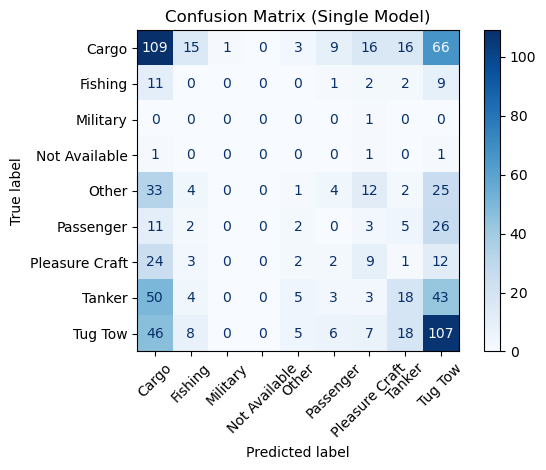

In [59]:
# Evaluate the trained model
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

# Get the mapping from group IDs to group names
id_to_vessel_group = {v: k for k, v in gp_regression_dataset.vessel_group_to_id.items()}

# Calculate accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {accuracy:.4f}")

# Get unique classes present in predictions/labels
unique_present_classes = sorted(set(all_labels).union(set(all_preds)))
class_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_present_classes)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix (Single Model)')
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the trained model
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

# Get the mapping from group IDs to group names
id_to_vessel_group = {v: k for k, v in gp_regression_dataset.vessel_group_to_id.items()}

# Calculate accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {accuracy:.4f}")

# Get unique classes present in predictions/labels
unique_present_classes = sorted(set(all_labels).union(set(all_preds)))
class_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_present_classes)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix (Single Model)')
plt.tight_layout()
plt.show()

## 5-Fold Cross Validation Classification Predictions

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import SubsetRandomSampler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure k-fold cross validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics across folds
all_preds = []
all_labels = []
fold_accuracies = []

# Get all indices
dataset_size = len(kernel_classification_dataset)
indices = list(range(dataset_size))

print(f"Starting {k_folds}-fold cross validation on {dataset_size} samples")

# K-fold cross validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(indices)):
    print(f"\nFold {fold+1}/{k_folds}")
    
    # Create data samplers for train and test
    train_sampler = SubsetRandomSampler(train_ids)
    test_sampler = SubsetRandomSampler(test_ids)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        kernel_classification_dataset, batch_size=512, 
        sampler=train_sampler
    )
    test_loader = torch.utils.data.DataLoader(
        kernel_classification_dataset, batch_size=512,
        sampler=test_sampler
    )
    
    # Get the input dimension from the dataset
    input_dim = kernel_classification_dataset.data[0][1].shape[0]
    print(f"Input dimension: {input_dim}")
    
    # Initialize model, loss function, and optimizer
    model = GPKernelShipClassificationNetwork(
        input_dim=input_dim, 
        num_classes=max(unique_group_ids) + 1
    ).to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    
    # Train the model
    trainer = GPKernelShipClassificationTrainer(
        model, train_loader, test_loader, criterion, optimizer, device
    )
    trainer.train(num_epochs=5000)  # Reduced epochs for quicker k-fold demo
    
    # Evaluate on the test set
    fold_preds = []
    fold_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            mmsi, X, y = batch
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            fold_preds.extend(preds)
            fold_labels.extend(y.cpu().numpy())
    
    # Calculate fold accuracy
    fold_accuracy = np.mean(np.array(fold_preds) == np.array(fold_labels))
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")
    
    # Add to overall results
    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

# Calculate and display overall metrics
print("\n==== Cross-Validation Results ====")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")

# Get the mapping from group IDs to group names
id_to_vessel_group = {v: k for k, v in gp_regression_dataset.vessel_group_to_id.items()}

# Get unique classes that are actually present in the predictions/labels
unique_present_classes = sorted(set(all_labels).union(set(all_preds)))

# Create class labels only for classes present in the data
class_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]

# Generate and plot the aggregate confusion matrix with proper class labels
cm = confusion_matrix(all_labels, all_preds, labels=unique_present_classes)
plt.figure(figsize=(14, 12))



Starting 5-fold cross validation on 3850 samples

Fold 1/5
Input dimension: 56


GP Kernel Ship Classification Training: 100%|██████████| 5000/5000 [01:46<00:00, 46.77it/s]


Fold 1 Accuracy: 0.3481

Fold 2/5
Input dimension: 56


GP Kernel Ship Classification Training: 100%|██████████| 5000/5000 [01:42<00:00, 48.83it/s]


Fold 2 Accuracy: 0.3571

Fold 3/5
Input dimension: 56


GP Kernel Ship Classification Training: 100%|██████████| 5000/5000 [01:30<00:00, 55.05it/s]


Fold 3 Accuracy: 0.3584

Fold 4/5
Input dimension: 56


GP Kernel Ship Classification Training: 100%|██████████| 5000/5000 [01:30<00:00, 55.22it/s]


Fold 4 Accuracy: 0.4026

Fold 5/5
Input dimension: 56


GP Kernel Ship Classification Training: 100%|██████████| 5000/5000 [01:32<00:00, 53.78it/s]

Fold 5 Accuracy: 0.3792

==== Cross-Validation Results ====
Mean Accuracy: 0.3691 ± 0.0196


<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

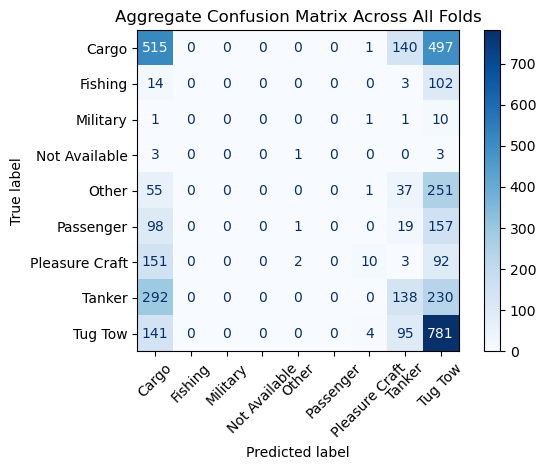


Classification Report:
                precision    recall  f1-score   support

         Cargo       0.41      0.45      0.43      1153
       Fishing       0.00      0.00      0.00       119
      Military       0.00      0.00      0.00        13
 Not Available       0.00      0.00      0.00         7
         Other       0.00      0.00      0.00       344
     Passenger       0.00      0.00      0.00       275
Pleasure Craft       0.59      0.04      0.07       258
        Tanker       0.32      0.21      0.25       660
       Tug Tow       0.37      0.76      0.50      1021

      accuracy                           0.38      3850
     macro avg       0.19      0.16      0.14      3850
  weighted avg       0.31      0.38      0.31      3850


Class Distribution in Dataset:
Cargo: 1153 samples
Fishing: 119 samples
Military: 13 samples
Not Available: 7 samples
Other: 344 samples
Passenger: 275 samples
Pleasure Craft: 258 samples
Tanker: 660 samples
Tug Tow: 1021 samples


/home/daniel/miniconda3/envs/gp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/miniconda3/envs/gp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/daniel/miniconda3/envs/gp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [ ]:

sns.reset_orig() 
# Create the confusion matrix with class names that match the matrix dimensions
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap='Blues', xticks_rotation=45)  # Rotate labels for better readability
plt.title('Aggregate Confusion Matrix Across All Folds')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Generate classification report with descriptive class names
print("\nClassification Report:")
target_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]
print(classification_report(all_labels, all_preds, labels=unique_present_classes, target_names=target_names))

# Print class distribution
print("\nClass Distribution in Dataset:")
class_counts = {}
for label in all_labels:
    class_name = id_to_vessel_group.get(label, f"Unknown ({label})")
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

for class_name, count in sorted(class_counts.items()):
    print(f"{class_name}: {count} samples")


In [104]:
def run_trajectory_ablation_study(models, gp_regression_dataset, device, 
                                  trajectory_counts=[10, 100, 500, 1000, 3850],
                                  num_trials=3, epochs=100, seed=42):
    """
    Run an ablation study on how the number of trajectories affects classification accuracy,
    using consistent class counts across all trajectory sizes.
    """
    import numpy as np
    import torch
    import random
    from sklearn.metrics import accuracy_score
    from torch.utils.data import random_split
    import matplotlib.pyplot as plt
    
    # Set seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Results storage
    results = {
        'trajectories': trajectory_counts,
        'accuracies': [],
        'std_devs': []
    }
    
    # Full model count
    total_models = len(models)
    print(f"Total available models: {total_models}")
    
    # Ensure trajectory counts are sorted
    trajectory_counts = sorted(trajectory_counts)
    max_count = trajectory_counts[-1]
    
    if max_count > total_models:
        print(f"Warning: Requested {max_count} trajectories but only have {total_models}")
        max_count = total_models
        
    # Track accuracies for each count and trial
    all_accuracies = {count: [] for count in trajectory_counts}
    
    # First determine the classes present in the largest dataset
    # This ensures all models are trained with the same number of classes
    print("\nCreating full dataset to determine class structure...")
    all_mmsis = list(models.keys())
    full_sampled_mmsis = random.sample(all_mmsis, max_count)
    full_sampled_models = {mmsi: models[mmsi] for mmsi in full_sampled_mmsis}
    
    full_dataset = GPKernelShipClassificationDataset(
        gp_regression_dataset, 
        full_sampled_models,
        device,
        scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi
    )
    
    # Get the full set of classes we need to predict across all trajectories
    all_unique_groups = full_dataset.get_unique_group_ids()
    num_classes = max(all_unique_groups) + 1
    
    print(f"Using consistent class count: {len(all_unique_groups)} classes (0-{max(all_unique_groups)})\n")
    
    # Run multiple trials
    for trial in range(num_trials):
        print(f"\n==== Trial {trial+1}/{num_trials} ====")
        
        # Randomly sample the maximum number of models needed
        sampled_mmsis = random.sample(all_mmsis, max_count)
        
        # For each trajectory count (in ascending order)
        for count in trajectory_counts:
            # Take only the first 'count' models for this iteration
            current_mmsis = sampled_mmsis[:count]
            sampled_models = {mmsi: models[mmsi] for mmsi in current_mmsis}
            
            print(f"  Testing with {count} trajectories")
            kernel_dataset = GPKernelShipClassificationDataset(
                gp_regression_dataset, 
                sampled_models,
                device,
                scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi
            )
            
            # Get actual classes in this dataset (for logging purposes)
            dataset_unique_groups = kernel_dataset.get_unique_group_ids()
            print(f"    Number of samples: {len(kernel_dataset)}")
            print(f"    Actual classes in this subset: {len(dataset_unique_groups)}")
            print(f"    Total classes to predict: {len(all_unique_groups)}")
            
            # Split dataset
            train_size = int(0.8 * len(kernel_dataset))
            test_size = len(kernel_dataset) - train_size
            train_dataset, test_dataset = random_split(kernel_dataset, [train_size, test_size])
            
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)
            
            # Create and train model with the full class count
            input_dim = kernel_dataset.data[0][1].shape[0]
            model = GPKernelShipClassificationNetwork(
                input_dim=input_dim, 
                num_classes=num_classes  # Use consistent class count
            ).to(device)
            
            # Handle class imbalance with weighted loss
            if len(all_unique_groups) > 1:
                class_counts = {}
                for _, _, label in kernel_dataset.data:
                    # Handle both tensor and integer labels
                    if hasattr(label, 'item'):
                        label_idx = label.item()
                    else:
                        label_idx = int(label)
                    
                    class_counts[label_idx] = class_counts.get(label_idx, 0) + 1
                
                weights = []
                total_samples = len(kernel_dataset)
                for i in range(num_classes):
                    if i in class_counts and class_counts[i] > 0:
                        weights.append(total_samples / (len(class_counts) * class_counts[i]))
                    else:
                        weights.append(1.0)  # Weight for classes not in this subset
                
                class_weights = torch.tensor(weights, dtype=torch.float).to(device)
                criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
            else:
                criterion = torch.nn.CrossEntropyLoss()
            
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Train
            trainer = GPKernelShipClassificationTrainer(
                model, train_loader, test_loader, criterion, optimizer, device
            )
            trainer.train(num_epochs=epochs)
            
            # Evaluate
            test_preds, test_labels = [], []
            model.eval()
            with torch.no_grad():
                for batch in test_loader:
                    mmsi, X, y = batch
                    X, y = X.to(device), y.to(device)
                    outputs = model(X)
                    preds = outputs.argmax(dim=1).cpu().numpy()
                    test_preds.extend(preds)
                    test_labels.extend(y.cpu().numpy())
            
            test_acc = accuracy_score(test_labels, test_preds) * 100  # Convert to percentage
            print(f"    Test accuracy: {test_acc:.2f}%")
            all_accuracies[count].append(test_acc)
    
    # Calculate statistics for each trajectory count
    for count in trajectory_counts:
        mean_acc = np.mean(all_accuracies[count])
        std_acc = np.std(all_accuracies[count])
        results['accuracies'].append(mean_acc)
        results['std_devs'].append(std_acc)
        print(f"Average accuracy for {count} trajectories: {mean_acc:.2f}% ± {std_acc:.2f}%")

    # Create plot and display results
    plt.figure(figsize=(8, 5))
    plt.errorbar(
        results['trajectories'], 
        results['accuracies'], 
        yerr=results['std_devs'], 
        fmt='o-', 
        capsize=5, 
        elinewidth=1.2, 
        markerfacecolor='blue'
    )
    
    plt.xlabel("Number of Trained Trajectories")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Classification Test Accuracy vs. Number of Trained Trajectories")
    plt.grid(True)
    
    # Use log scale if range is large
    if max(results['trajectories']) / min(results['trajectories']) > 10:
        plt.xscale('log')
        plt.xticks(results['trajectories'], labels=[str(n) for n in results['trajectories']])
    
    plt.tight_layout()
    plt.show()
    
    # Print results table
    print("\n===== Results =====")
    print(f"{'Trajectories':<15} {'Accuracy (%)':<15} {'Std Dev':<10}")
    print("-" * 40)
    for i, count in enumerate(results['trajectories']):
        print(f"{count:<15} {results['accuracies'][i]:.2f}%{' ':<8} {results['std_devs'][i]:.2f}%")
    
    return results

Total available models: 3850

Creating full dataset to determine class structure...
Using consistent class count: 9 classes (0-8)


==== Trial 1/5 ====
  Testing with 100 trajectories
    Number of samples: 100
    Actual classes in this subset: 7
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:05<00:00, 85.15it/s] 


    Test accuracy: 10.00%
  Testing with 500 trajectories
    Number of samples: 500
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:05<00:00, 94.15it/s] 


    Test accuracy: 14.00%
  Testing with 1000 trajectories
    Number of samples: 1000
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:08<00:00, 58.69it/s]


    Test accuracy: 12.00%
  Testing with 3850 trajectories
    Number of samples: 3850
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:19<00:00, 25.68it/s]


    Test accuracy: 29.74%

==== Trial 2/5 ====
  Testing with 100 trajectories
    Number of samples: 100
    Actual classes in this subset: 7
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:04<00:00, 102.82it/s]


    Test accuracy: 15.00%
  Testing with 500 trajectories
    Number of samples: 500
    Actual classes in this subset: 8
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:04<00:00, 107.08it/s]


    Test accuracy: 16.00%
  Testing with 1000 trajectories
    Number of samples: 1000
    Actual classes in this subset: 8
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:05<00:00, 93.96it/s] 


    Test accuracy: 16.50%
  Testing with 3850 trajectories
    Number of samples: 3850
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:28<00:00, 17.68it/s]


    Test accuracy: 31.17%

==== Trial 3/5 ====
  Testing with 100 trajectories
    Number of samples: 100
    Actual classes in this subset: 7
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:05<00:00, 96.32it/s] 


    Test accuracy: 15.00%
  Testing with 500 trajectories
    Number of samples: 500
    Actual classes in this subset: 7
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:03<00:00, 146.73it/s]


    Test accuracy: 20.00%
  Testing with 1000 trajectories
    Number of samples: 1000
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:04<00:00, 115.32it/s]


    Test accuracy: 15.50%
  Testing with 3850 trajectories
    Number of samples: 3850
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:23<00:00, 21.66it/s]


    Test accuracy: 19.74%

==== Trial 4/5 ====
  Testing with 100 trajectories
    Number of samples: 100
    Actual classes in this subset: 7
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:03<00:00, 156.65it/s]


    Test accuracy: 15.00%
  Testing with 500 trajectories
    Number of samples: 500
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:03<00:00, 156.91it/s]


    Test accuracy: 17.00%
  Testing with 1000 trajectories
    Number of samples: 1000
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:04<00:00, 115.39it/s]


    Test accuracy: 18.00%
  Testing with 3850 trajectories
    Number of samples: 3850
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:24<00:00, 20.31it/s]


    Test accuracy: 30.26%

==== Trial 5/5 ====
  Testing with 100 trajectories
    Number of samples: 100
    Actual classes in this subset: 8
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:05<00:00, 87.06it/s] 


    Test accuracy: 10.00%
  Testing with 500 trajectories
    Number of samples: 500
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:03<00:00, 143.39it/s]


    Test accuracy: 12.00%
  Testing with 1000 trajectories
    Number of samples: 1000
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:06<00:00, 82.41it/s]


    Test accuracy: 13.50%
  Testing with 3850 trajectories
    Number of samples: 3850
    Actual classes in this subset: 9
    Total classes to predict: 9


GP Kernel Ship Classification Training: 100%|██████████| 500/500 [00:14<00:00, 34.04it/s]


    Test accuracy: 34.81%
Average accuracy for 100 trajectories: 13.00% ± 2.45%
Average accuracy for 500 trajectories: 15.80% ± 2.71%
Average accuracy for 1000 trajectories: 15.10% ± 2.13%
Average accuracy for 3850 trajectories: 29.14% ± 5.02%


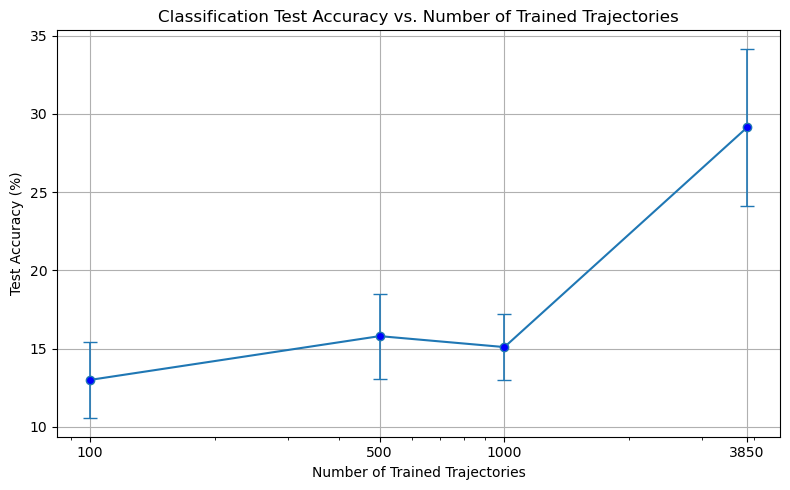


===== Results =====
Trajectories    Accuracy (%)    Std Dev   
----------------------------------------
100             13.00%         2.45%
500             15.80%         2.71%
1000            15.10%         2.13%
3850            29.14%         5.02%


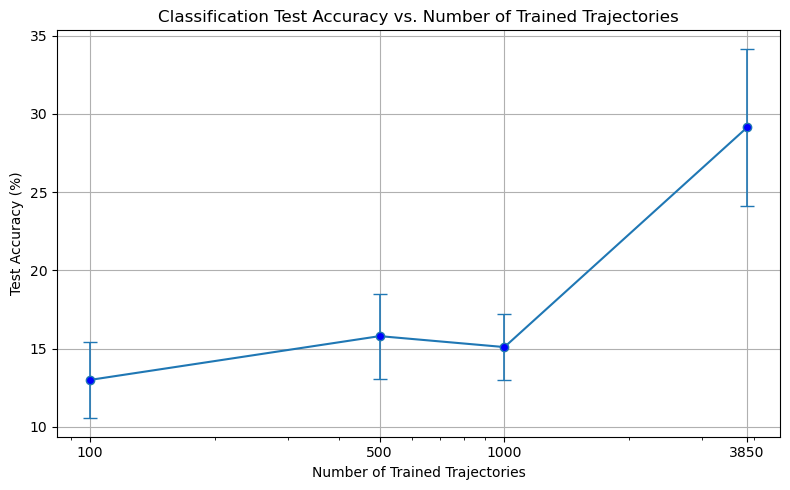

In [ ]:
ablation_results = run_trajectory_ablation_study(
    models=models,
    gp_regression_dataset=gp_regression_dataset,
    device=device,
    trajectory_counts=[100, 500, 1000, 3850],  # Adjust based on # of available models
    num_trials=5,  # Increase for more reliable statistics
    epochs=500     # Training epochs per model
)



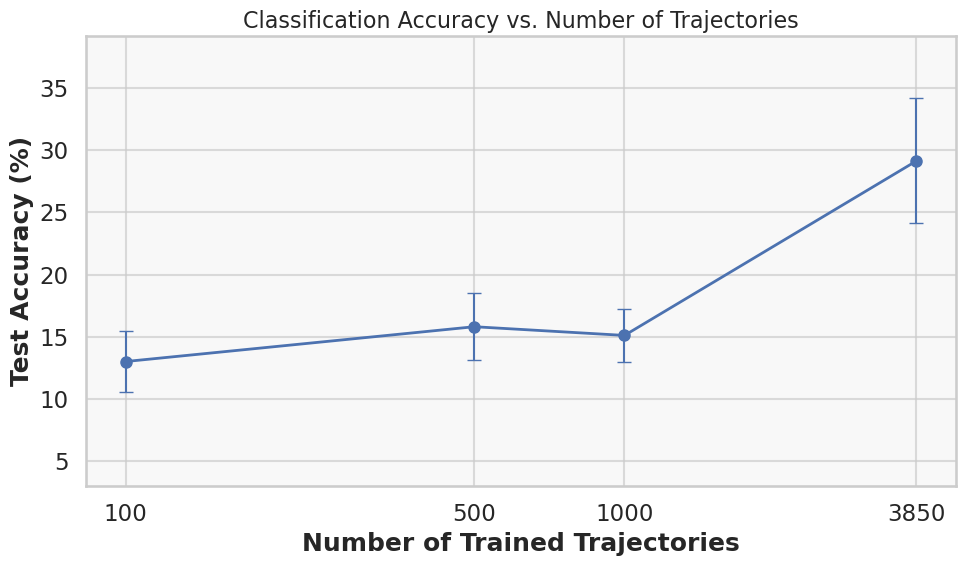

In [110]:
import seaborn as sns

# Set Seaborn style
sns.set_theme(style="whitegrid", context="talk")  # Options: whitegrid, darkgrid, white, dark, ticks
# Use a pleasing color palette
palette = sns.color_palette("deep")

trajectories = ablation_results['trajectories']
accuracy = ablation_results['accuracies']
std_dev = ablation_results['std_devs']

plt.figure(figsize=(10, 6))
plt.errorbar(
    trajectories, 
    accuracy, 
    yerr=std_dev, 
    fmt='o-', 
    capsize=5, 
    elinewidth=1.5, 
    markerfacecolor=palette[0],
    color=palette[0],
    markersize=8,
    linewidth=2
)

plt.xlabel("Number of Trained Trajectories", fontweight='bold')
plt.ylabel("Test Accuracy (%)", fontweight='bold')
plt.title("Classification Accuracy vs. Number of Trajectories", fontsize=16)
plt.grid(True, alpha=0.7)
plt.xscale('log')  # Makes it easier to visualize large range
plt.xticks(trajectories, labels=[str(n) for n in trajectories])

# Add min/max y-axis padding for better visualization
y_min = max(0, min(accuracy) - max(std_dev) - 5)
y_max = min(100, max(accuracy) + max(std_dev) + 5)
plt.ylim(y_min, y_max)

# Add a subtle background color
plt.gca().set_facecolor('#f8f8f8')

plt.tight_layout()
plt.show()